<a href="https://colab.research.google.com/github/hiydavid/time-series/blob/main/rnn_lstm_models_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with TensorFlow

Link: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

---
# Load Libraries

In [ ]:
# load libraries
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
from pathlib import Path

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

---
# Create time series generation

In [ ]:
# create function
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
# create time series
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

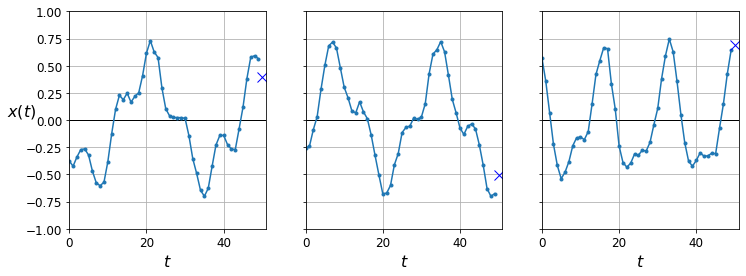

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], 
                y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

---
# Baseline forecast

In [ ]:
# naive forecast MSE
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

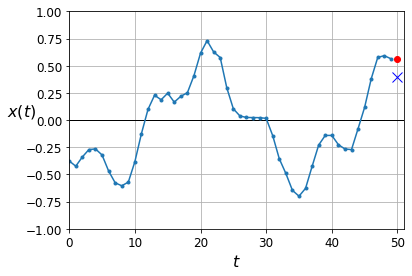

In [ ]:
# show naive pred
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

---
# One-step ahead forecast

## Linear model

In [ ]:
# linear model (flatten)
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
    ])

model.compile(loss="mse", optimizer="adam")
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 5ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0062

In [ ]:
# linear model eval
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

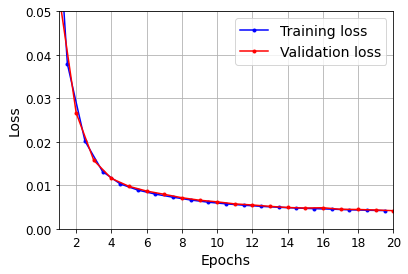

In [ ]:
# function to plot learning curves
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

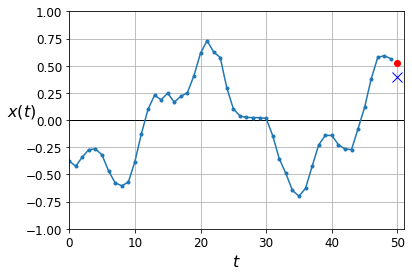

In [ ]:
# plot linear model
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Simple RNN model

In [ ]:
# simple rnn with one layer
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 11s 46ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0117 - 

In [ ]:
# simple rnn eval
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0109


0.010881561785936356

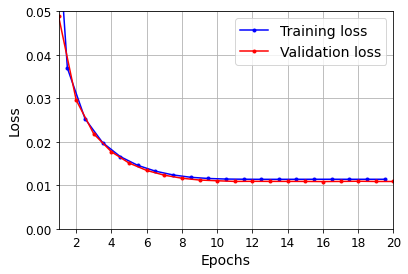

In [ ]:
# plot simple rnn learning curve
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

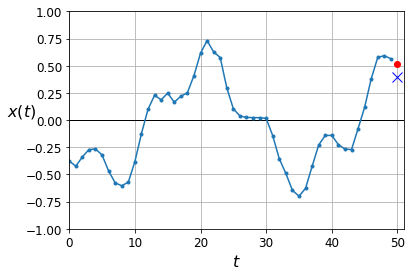

In [ ]:
# plot simple rnn
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNN model

In [ ]:
# rnn model
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
    ])

model.compile(loss="mse", optimizer="adam")
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 31s 131ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 29s 133ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 28s 129ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 28s 126ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 28s 128ms/step - l

In [ ]:
# deep rnn eval
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0029


0.0029105613939464092

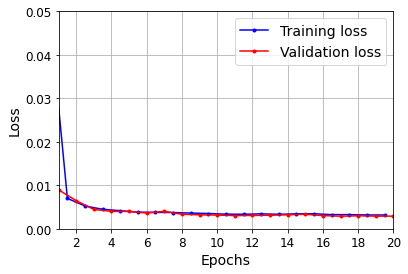

In [ ]:
# plot deep rnn learning curve
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

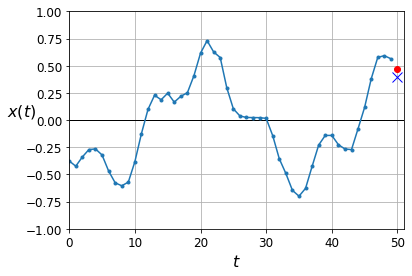

In [ ]:
# plot deep rnn learning
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

---
# Forecasting several steps ahead

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

Y_pred.shape

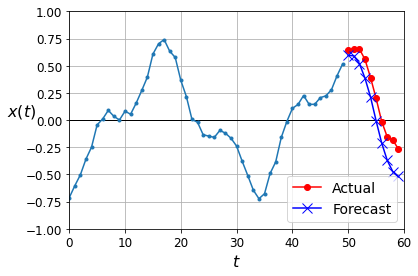

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()